In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchinfo import summary
from PIL import Image
import os
from data_setup import pred_df, CutOut, train_transform, test_transform, FoodDataset
from engine import train_step, test_step, train
from model_builder import CLIPFineTuner

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import os
from pathlib import Path

data_path = Path("Data/food-101/")
image_path = data_path / "food-101"
print(image_path)

Data\food-101\food-101


In [4]:
print("Input file: ")
print(os.listdir(image_path))

Input file: 
['.DS_Store', 'images', 'license_agreement.txt', 'meta', 'README.txt']


In [5]:
print(f"Meta file: {os.listdir(image_path / 'meta')}")
print(f"Imgs file: {os.listdir(image_path / 'images')}")


Meta file: ['classes.txt', 'labels.txt', 'test.json', 'test.txt', 'test_reduced.txt', 'train.json', 'train.txt', 'train_reduced.txt']
Imgs file: ['.DS_Store', 'apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_s

In [6]:
class_names = open(f"{image_path / 'meta'}\\classes.txt", "r").read().splitlines()
print(f"Len of Class_names: {len(class_names)}")
class_names[:5]

Len of Class_names: 101


['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [7]:
train_images = open(f"{image_path / 'meta'}\\train_reduced.txt", "r").read().splitlines()
test_images = open(f"{image_path / 'meta'}\\test_reduced.txt", "r").read().splitlines()
print(f"Length of Train Imgs: {len(train_images)}: {train_images[:5]}")
print(f"Length of Test Imgs: {len(test_images)}: {test_images[:5]}")


Length of Train Imgs: 30300: ['apple_pie/330431', 'apple_pie/2713820', 'apple_pie/1646808', 'apple_pie/2288697', 'apple_pie/2523745']
Length of Test Imgs: 10100: ['apple_pie/3027601', 'apple_pie/1068632', 'apple_pie/2446500', 'apple_pie/2038171', 'apple_pie/2596943']


In [8]:
class_dic = {name: idx for idx, name in enumerate(class_names)}
class_dic

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheesecake': 16,
 'cheese_plate': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

In [9]:
train_dir = image_path / "meta/train_reduced.txt"
test_dir = image_path / "meta/test_reduced.txt"
train_imgs = pred_df(train_dir, class_dic)
test_imgs = pred_df(test_dir, class_dic)
train_imgs.groupby(["label"]).count()

,path,label_idx
label,,
apple_pie,300,300
baby_back_ribs,300,300
baklava,300,300
beef_carpaccio,300,300
beef_tartare,300,300
...,...,...
tacos,300,300
takoyaki,300,300
tiramisu,300,300


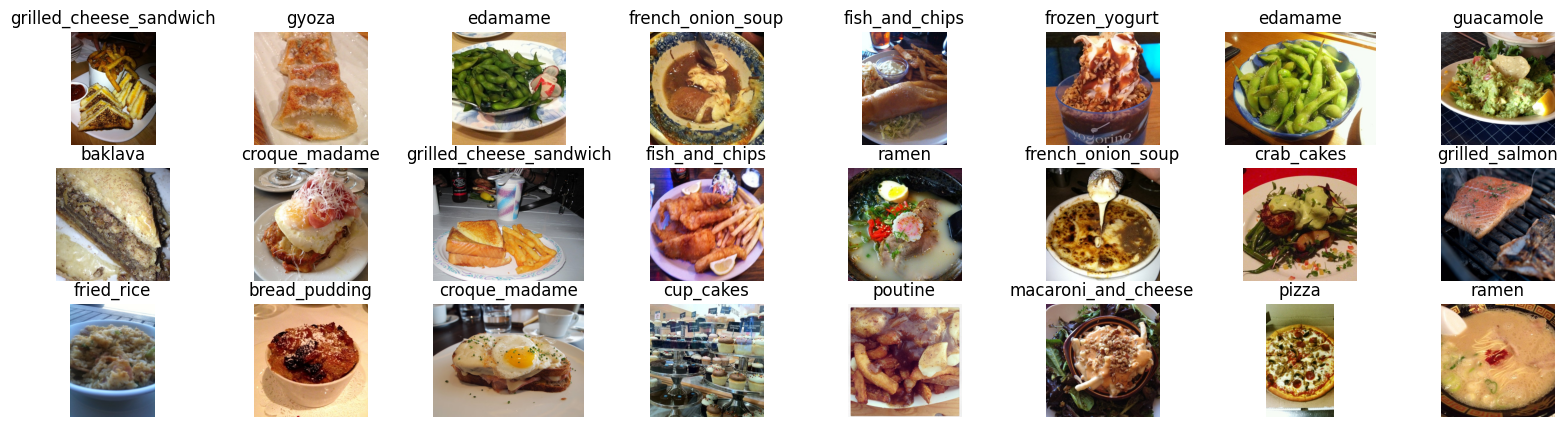

In [10]:
plt.figure(figsize=(20, 5))

num_rows = 3
num_cols = 8


for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])

    label = train_imgs.label.iloc[random_idx]

    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

In [11]:
train_imgs

,path,label,label_idx
21129,Data/food-101/food-101/images/pad_thai/636159.jpg,pad_thai,70
15933,Data/food-101/food-101/images/hamburger/262245...,hamburger,53
7505,Data/food-101/food-101/images/club_sandwich/65...,club_sandwich,25
28525,Data/food-101/food-101/images/sushi/840444.jpg,sushi,95
19438,Data/food-101/food-101/images/miso_soup/161669...,miso_soup,64
...,...,...,...
29802,Data/food-101/food-101/images/tuna_tartare/101...,tuna_tartare,99
5390,Data/food-101/food-101/images/cheesecake/10556...,cheesecake,16
860,Data/food-101/food-101/images/baklava/3093742.jpg,baklava,2
15795,Data/food-101/food-101/images/gyoza/1267176.jpg,gyoza,52


In [12]:
train_dataset = FoodDataset(train_imgs, transform=train_transform)
test_dataset = FoodDataset(test_imgs, transform=test_transform)
train_dataset

In [13]:
BATCH_SIZE = 32
NUM_WORKERS = 8 #os.cpu_count()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    pin_memory=True
)


In [14]:
print(f"\nNumber of training batches: {len(train_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")



Number of training batches: 947
Number of test batches: 316


In [15]:
import clip 
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [16]:
summary(
    model=model.visual,
    input_size=(32, 3, 224, 224),
    dtypes=[torch.float16],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)              [32, 3, 224, 224]    [32, 512]            432,384              True
├─Conv2d (conv1)                                   [32, 3, 224, 224]    [32, 768, 7, 7]      2,359,296            True
├─LayerNorm (ln_pre)                               [32, 50, 768]        [32, 50, 768]        1,536                True
├─Transformer (transformer)                        [50, 32, 768]        [50, 32, 768]        --                   True
│    └─Sequential (resblocks)                      [50, 32, 768]        [50, 32, 768]        --                   True
│    │    └─ResidualAttentionBlock (0)             [50, 32, 768]        [50, 32, 768]        7,087,872            True
│    │    └─ResidualAttentionBlock (1)             [50, 32, 768]        [50, 32, 768]        7,087,872            True
│    │    └─ResidualAttentionBlock (2)     

In [17]:
num_classes = len(class_names)
model_ft = CLIPFineTuner(model, num_classes).to(device)

In [18]:
summary(
    model=model_ft,
    input_size=(32, 3, 224, 224),
    dtypes=[torch.float16],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
    verbose=0
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
CLIPFineTuner (CLIPFineTuner)                                [32, 3, 224, 224]    [32, 101]            --                   True
├─CLIP (model)                                               --                   --                   63,428,097           True
│    └─VisionTransformer (visual)                            [32, 3, 224, 224]    [32, 512]            432,384              True
│    │    └─Conv2d (conv1)                                   [32, 3, 224, 224]    [32, 768, 7, 7]      2,359,296            True
│    │    └─LayerNorm (ln_pre)                               [32, 50, 768]        [32, 50, 768]        1,536                True
│    │    └─Transformer (transformer)                        [50, 32, 768]        [50, 32, 768]        85,054,464           True
│    │    └─LayerNorm (ln_post)                              [32, 768]            [32, 768] 

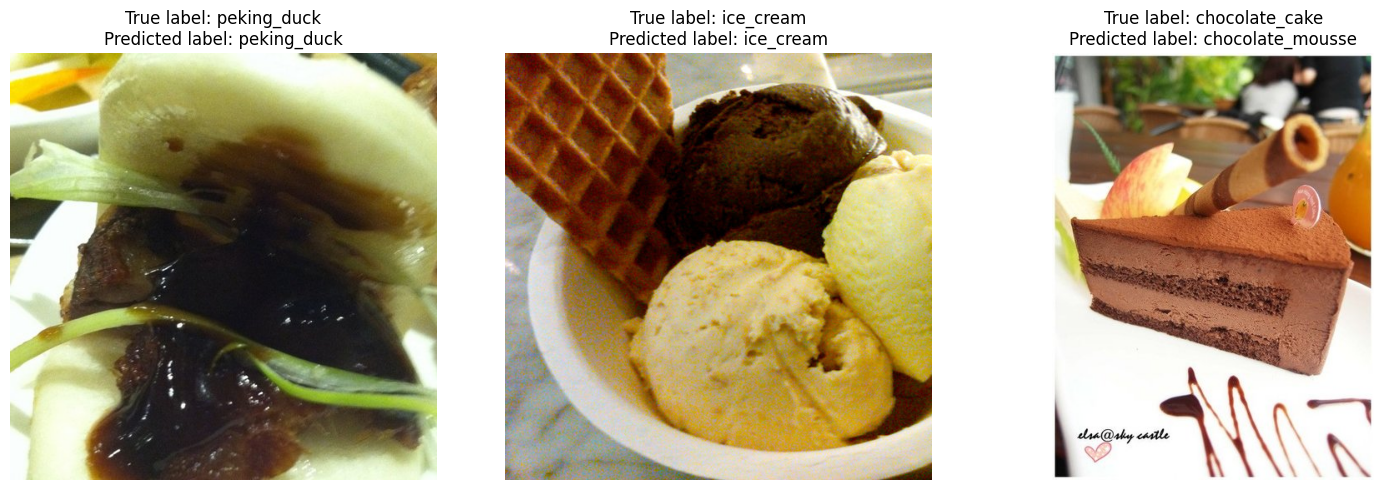

In [19]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

model_ft.load_state_dict(torch.load('clip_finetuned.pth'))
model_ft.eval()  

indices = [0,1,2]
index_to_class = {idx: name for name, idx in class_dic.items()}
# Preprocess the image
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
# ])
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, idx in enumerate(indices):
    # Get the image and label from the dataset
    item = test_imgs.iloc[idx]
    image = item['path']
    true_label = item['label']
    image = Image.open(image)
    # Transform the image
    img_tran = transform(image)
    image_tensor = transform(image).unsqueeze(0).to(device) 

    with torch.no_grad():
        output = model_ft(image_tensor)
        _, predicted_label_idx = torch.max(output, 1)
        predicted_label = index_to_class[predicted_label_idx.item()]

    axes[i].imshow(image)
    axes[i].set_title(f'True label: {true_label}\nPredicted label: {predicted_label}')
    axes[i].axis('off')


plt.tight_layout()
plt.show()


In [37]:
import json

def plot_loss_curve(json_path: str = 'train_results.json') -> None:
    
    with open(json_path, 'r') as f:
        results = json.load(f)

    train_loss = results['train_loss']
    train_acc = results['train_acc']
    test_loss = results['test_loss']
    test_acc = results['test_acc']
    print(f"Train loss: {train_loss[-1]}")
    print(f"Train acc: {train_acc[-1]}")
    print(f"Test loss: {test_loss[-1]}")
    print(f"Test acc: {test_acc[-1]}")

    epochs = range(len(train_loss))

    plt.figure(figsize=(10, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, c='g', label='Train loss')
    plt.plot(epochs, test_loss, c='r', label='Test loss')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, c='g', label='Train acc')
    plt.plot(epochs, test_acc, c='r', label='Test acc')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

Train loss: 1.0542585772030457
Train acc: 72.63036303630363
Test loss: 0.47957959488222873
Test acc: 87.15841584158416


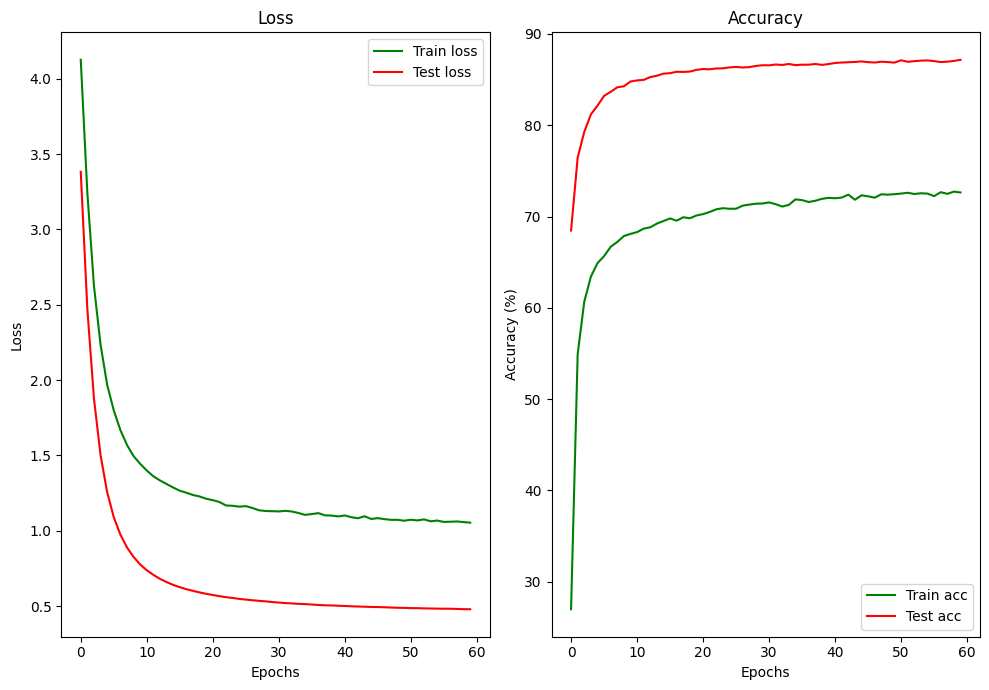

In [38]:
plot_loss_curve()

In [20]:
def pred_and_plot(model, image_path, class_dic, transform, device):
    index_to_class = {idx: name for name, idx in class_dic.items()}
    true_label = test_imgs[test_imgs['path'] == image_path]['label'].iloc[0]
    print(true_label)
    image = Image.open(image_path)
    # Transform the image
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    model.to(device)
    model.eval()
    with torch.no_grad():
        output = model_ft(image_tensor)
        _, predicted_label_idx = torch.max(output, 1)
        predicted_label = index_to_class[predicted_label_idx.item()]

    plt.figure()
    plt.imshow(image)
    plt.title(f"True label: {true_label}\nPredicted label: {predicted_label}")
    plt.axis('off')


grilled_cheese_sandwich


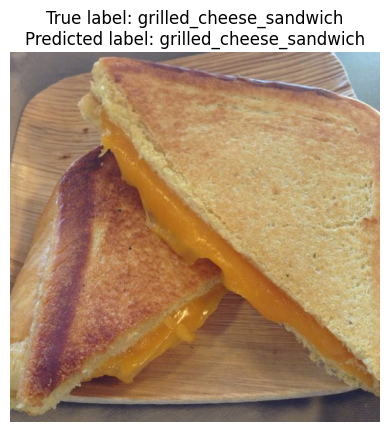

In [26]:
pred_and_plot(model_ft, test_imgs.iloc[100]['path'], class_dic, transform, device)

In [22]:

import requests
from io import BytesIO
def pred_and_plot_from_url(model, url, class_dic, transform, device):
    index_to_class = {idx: name for name, idx in class_dic.items()}

    # Tải ảnh từ URL
    response = requests.get(url, timeout=10)
    response.raise_for_status()  # Kiểm tra lỗi HTTP
    image = Image.open(BytesIO(response.content))
    if image.mode != 'RGB':
        image = image.convert('RGB')
   
    image_tensor = transform(image).unsqueeze(0).to(device)  # Thêm batch dimension
    
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_label_idx = torch.max(output, 1)
        predicted_label = index_to_class.get(predicted_label_idx.item(), "Unknown")

    image_np = np.array(image)
    if image_np.shape[2] != 3:
        image_np = image_np[:, :, :3]

    # Hiển thị ảnh
    plt.figure()
    plt.imshow(image_np)
    plt.title(f"Predicted label: {predicted_label}")
    plt.axis('off')
    plt.show()

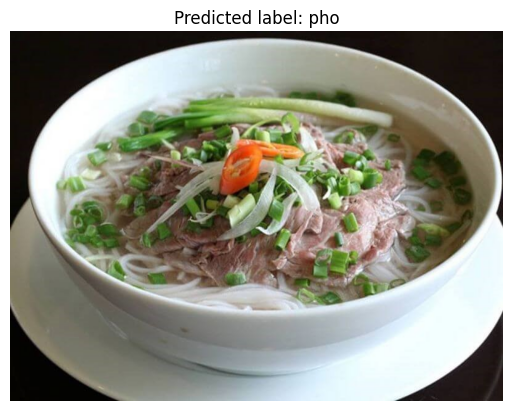

In [23]:
url = "https://vietfood.org.vn/wp-content/uploads/2020/12/Pho1.jpg"
# url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRAmW4TXOvSAEKudVyzdELnRImrPI3b5VuAtA&s"
# url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRDjrfzSMj3Y7WalwB1cA5cb0wnIT-_8sMa5g&s"
# url = "https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcRtd_ffQLd2xWg9iW7DaSQirddjFFVC_zr_iVcNMieE-22Vqj2IPNGc3YT4dWIeO5iPdJJfOgF_djuWRsAJnt8iGI_kVnd8Z9rWwvwJj1I"
pred_and_plot_from_url(model_ft, url, class_dic, transform, device)